# Analyzing and Predicting Universal Studio Review Ratings

 Author: Paolo Pedrigal

## Table of Contents

### 1. Introduction
     1.1 About Universal Studios Theme Park
     1.2 Explaining the Dataset
     1.3 Sources
     
### 2. Analyzing the Dataset (EDA)
    2.1 Getting the data.
    2.2 Finding the top 10 most frequent words based on rating.
    2.3 How frequent were there reviews over a period of time?
    2.4 Which branch tends to yield higher-rated reviews? Which branch tends to yield lower-rated reviews?
    
### 3. Preparing and Predicting the Data
     3.1 Preparing data for training and testing
     3.2 Train and test ML model
     3.3 Determining the accuracy of our model
     
### 4. Final Remarks

__________________________________________________________________________________________________

### 1. Introduction

#### 1.1. About Universal Studios Theme Park

Universal Studios Theme Park is multi-branch theme park that includes rides, entertainment, food, and more. The theme parks are all based on the motion pictures produced by Universal Studios.

#### 1.2 Explaining this Project

In this project, I will be conducting exploratory data analysis of the given dataset, including figuring out what common words are their in certain rated reviews, seeing how frequent reviews occured over the years and within a calendar year, and comparing review ratings by branch. I will also be diving into natural language processing to see if we can predict 1-star and 5-star rated reviews.

I decided to choose this topic because I have recently went to Disneyland, another theme park, and was curious if I could apply my knowledge of data science towards theme park ratings.

The input data is a CSV file, containing 50,904 entries of reviews. 

For convience, when I refer to Universal Studios, I am really referring to the theme park.

#### 1.3 Sources

Original source: https://www.kaggle.com/dwiknrd/reviewuniversalstudio	(Kaggle)

### 2. Analyzing the Dataset (EDA)

#### 2.1 Getting the data.

Importing libraries for EDA and ML.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import RegexpTokenizer
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

Creating a raw dataframe from our source file.


In [2]:
df = pd.read_csv("universal_studio_branches.csv")
print("Number of entries:", df.shape[0])
print("Column names:", ", ".join(df.columns.values))

Number of entries: 50904
Column names: reviewer, rating, written_date, title, review_text, branch


Let's take a peak into the dataframe.

In [3]:
df.head(10)

,reviewer,rating,written_date,title,review_text,branch
0,Kelly B,2.0,"May 30, 2021",Universal is a complete Disaster - stick with ...,We went to Universal over Memorial Day weekend...,Universal Studios Florida
1,Jon,1.0,"May 30, 2021",Food is hard to get.,The food service is horrible. I’m not reviewin...,Universal Studios Florida
2,Nerdy P,2.0,"May 30, 2021",Disappointed,I booked this vacation mainly to ride Hagrid m...,Universal Studios Florida
3,ran101278,4.0,"May 29, 2021",My opinion,When a person tries the test seat for the ride...,Universal Studios Florida
4,tammies20132015,5.0,"May 28, 2021",The Bourne Stuntacular...MUST SEE,"Ok, I can't stress enough to anyone and everyo...",Universal Studios Florida
5,John,1.0,"May 28, 2021",This is not a vacation,Worst experience I have ever had the rides are...,Universal Studios Florida
6,annapN7702ZW,2.0,"May 27, 2021",Expected More,"I just expected more. Alot of waiting around, ...",Universal Studios Florida
7,Deb P,2.0,"May 27, 2021",Disapointing.....,This was my 4th trip with my daughter to Unive...,Universal Studios Florida
8,Chuck N,1.0,"May 27, 2021",Greed makes for a terrible guest experience,Universal is one thing - Not Disney. Everythin...,Universal Studios Florida
9,Jen,4.0,"May 26, 2021",Good first time visit with kids,We spent 6 nights on site at Sapphire Falls as...,Universal Studios Florida


What branches are in Universal Studios, according to the dataframe? What type of ratings can a reviewer rate?

In [4]:
print("Branches:", ", ".join(df.branch.unique()))
print("Ratings:", *df.rating.unique())

Branches: Universal Studios Florida, Universal Studios Japan, Universal Studios Singapore
Ratings: 2.0 1.0 4.0 5.0 3.0


Let's change the rating column to integers.

In [5]:
df.rating = pd.to_numeric(df.rating, downcast="integer")
df.head(10)

,reviewer,rating,written_date,title,review_text,branch
0,Kelly B,2,"May 30, 2021",Universal is a complete Disaster - stick with ...,We went to Universal over Memorial Day weekend...,Universal Studios Florida
1,Jon,1,"May 30, 2021",Food is hard to get.,The food service is horrible. I’m not reviewin...,Universal Studios Florida
2,Nerdy P,2,"May 30, 2021",Disappointed,I booked this vacation mainly to ride Hagrid m...,Universal Studios Florida
3,ran101278,4,"May 29, 2021",My opinion,When a person tries the test seat for the ride...,Universal Studios Florida
4,tammies20132015,5,"May 28, 2021",The Bourne Stuntacular...MUST SEE,"Ok, I can't stress enough to anyone and everyo...",Universal Studios Florida
5,John,1,"May 28, 2021",This is not a vacation,Worst experience I have ever had the rides are...,Universal Studios Florida
6,annapN7702ZW,2,"May 27, 2021",Expected More,"I just expected more. Alot of waiting around, ...",Universal Studios Florida
7,Deb P,2,"May 27, 2021",Disapointing.....,This was my 4th trip with my daughter to Unive...,Universal Studios Florida
8,Chuck N,1,"May 27, 2021",Greed makes for a terrible guest experience,Universal is one thing - Not Disney. Everythin...,Universal Studios Florida
9,Jen,4,"May 26, 2021",Good first time visit with kids,We spent 6 nights on site at Sapphire Falls as...,Universal Studios Florida


#### 2.2 Finding the top 10 most frequent words based on rating.

Creating a function to preprocess the text in review_text. After preprocessing, the text will remove stop words, keep only English words, and stem each word.

In [6]:
stop_words=set(stopwords.words("english"))  # get the stop_words in english
stemmer = PorterStemmer()  # create a PorterStemmer object to stem any word
tokenizer = RegexpTokenizer("\w+") # only tokenize words
    
def preprocess(text):
    new_text = [stemmer.stem(word) for word in tokenizer.tokenize(text.lower()) if word not in stop_words]
    return " ".join(new_text)

Preprocess every review in the dataframe.

In [7]:
df_processed = pd.Series([preprocess(df.review_text.loc[i]) for i in range(df.shape[0])]).to_frame()
df_processed.columns = ["review_text"]
df_processed.head()

,review_text
0,went univers memori day weekend total train wr...
1,food servic horribl review food wait time 45 m...
2,book vacat mainli ride hagrid motorcycl advent...
3,person tri test seat ride get green light go l...
4,ok stress enough anyon everyon go univers stud...


Creating a function to get the top words from a dataframe.

In [8]:
def get_top_words(dataframe, top=10):
    string = ""
    for text in dataframe.values:
        string += str(text)
    tokenizer = RegexpTokenizer("[\w]+")
    words = tokenizer.tokenize(string)
#     words = [i[0] for i in nltk.pos_tag(words) if "NN" in i[1]]  # filter only nouns
    freqD = sorted(nltk.FreqDist(words).items(), key=lambda x:x[1], reverse=True)
    top_words = [pair[0] for pair in freqD[:top]] # top 10 words
    top_freq = [pair[1] for pair in freqD[:top]] # top 10 frequency counts for coresponding words
    return (top_words, top_freq)
    

Creating a funciton to plot the top words from a dataframe.

In [9]:
def plot_top_words(words, freq, title=""):
    plt.bar(range(len(freq)), freq)
    plt.xticks(range(len(words)), words, rotation=90)
    plt.title("Top " + str(len(words)) + " Words " + title)
    plt.ylabel("Frequency")
    plt.xlabel("Words ")
    plt.show()

Get top 10 most frequent words for 5 stars.

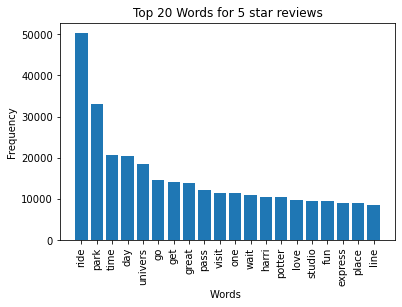

In [10]:
five_star = df_processed[df.rating == 5]
top_five = get_top_words(five_star, 20)
plot_top_words(top_five[0], top_five[1], title="for 5 star reviews")

Get top 10 most frequent words for 1 stars.

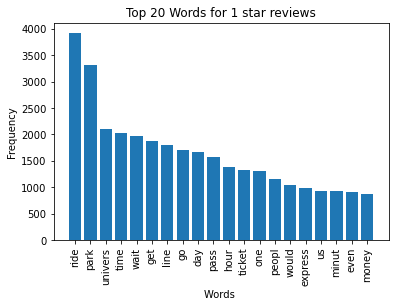

In [11]:
one_star = df_processed[df.rating == 1]
top_one = get_top_words(one_star, 20)
plot_top_words(top_one[0], top_one[1], title="for 1 star reviews")

Let's see what words are exclusive in each rating.

In [12]:
print("Top words in 5-star reviews, but not in 1-star reviews:", ", ".join(set(top_five[0]).difference(set(top_one[0]))))
print("Top words in 1-star reviews, but not in 5-star reviews:", ", ".join(set(top_one[0]).difference(set(top_five[0]))))

Top words in 5-star reviews, but not in 1-star reviews: love, studio, great, place, visit, fun, harri, potter
Top words in 1-star reviews, but not in 5-star reviews: minut, would, money, peopl, ticket, us, even, hour


#### 2.3 How frequent were there reviews over a period of time?

Let's first show time as years in the dataset to compare frequency of reviews and time in years.

In [13]:
years = pd.Series([re.search("([0-9]+)$", date).group() for date in df.written_date]).to_frame()
years.columns = ["year"]
df_by_year = pd.concat([years, df], axis=1).drop(columns=["written_date"])
df_by_year.head()

,year,reviewer,rating,title,review_text,branch
0,2021,Kelly B,2,Universal is a complete Disaster - stick with ...,We went to Universal over Memorial Day weekend...,Universal Studios Florida
1,2021,Jon,1,Food is hard to get.,The food service is horrible. I’m not reviewin...,Universal Studios Florida
2,2021,Nerdy P,2,Disappointed,I booked this vacation mainly to ride Hagrid m...,Universal Studios Florida
3,2021,ran101278,4,My opinion,When a person tries the test seat for the ride...,Universal Studios Florida
4,2021,tammies20132015,5,The Bourne Stuntacular...MUST SEE,"Ok, I can't stress enough to anyone and everyo...",Universal Studios Florida


What years are included in the dataset?

In [14]:
tot_years = sorted(years.year.unique(), reverse=False)
print("Years in dataset:", *tot_years)

Years in dataset: 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021


How many reviews were there in each year?

In [15]:
year_freq = {elem[0]:elem[1] for elem in zip(tot_years, df_by_year.groupby("year").count().values[:,0])}
year_freq

{'2002': 1,
 '2003': 7,
 '2004': 57,
 '2005': 40,
 '2006': 60,
 '2007': 80,
 '2008': 94,
 '2009': 169,
 '2010': 414,
 '2011': 998,
 '2012': 2270,
 '2013': 3789,
 '2014': 5452,
 '2015': 9101,
 '2016': 9300,
 '2017': 7143,
 '2018': 6175,
 '2019': 4470,
 '2020': 999,
 '2021': 285}

Let's depict this in a line graph.

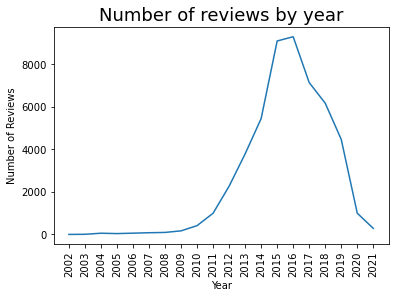

In [16]:
plt.plot(year_freq.keys(), year_freq.values())
plt.xlabel("Year")
plt.ylabel("Number of Reviews")
plt.title("Number of reviews by year", fontsize=18)
plt.xticks(rotation=90)
plt.show()

Now let's see how frequent reviews occur within the calendar year. We will first start by creating a month column.

In [17]:
months = pd.Series([re.search("^([A-Za-z]+)", date).group() for date in df.written_date]).to_frame()
months.columns = ["month"]
df_by_month = pd.concat([months, df], axis=1).drop(columns=["written_date"])
df_by_month.head()

,month,reviewer,rating,title,review_text,branch
0,May,Kelly B,2,Universal is a complete Disaster - stick with ...,We went to Universal over Memorial Day weekend...,Universal Studios Florida
1,May,Jon,1,Food is hard to get.,The food service is horrible. I’m not reviewin...,Universal Studios Florida
2,May,Nerdy P,2,Disappointed,I booked this vacation mainly to ride Hagrid m...,Universal Studios Florida
3,May,ran101278,4,My opinion,When a person tries the test seat for the ride...,Universal Studios Florida
4,May,tammies20132015,5,The Bourne Stuntacular...MUST SEE,"Ok, I can't stress enough to anyone and everyo...",Universal Studios Florida


How many reviews are there per month in a year?

In [18]:
month_freq_unsorted = {elem[0]: elem[1] for elem in zip(df_by_month.groupby("month").count().index.values, df_by_month.groupby("month").count().values[:,0])}
month_names = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October",
         "November", "December"]
month_freq = {name: month_freq_unsorted[name] for name in month_names}
month_freq

{'January': 4531,
 'February': 3218,
 'March': 3945,
 'April': 4444,
 'May': 3903,
 'June': 4267,
 'July': 5266,
 'August': 4978,
 'September': 4086,
 'October': 4692,
 'November': 3760,
 'December': 3814}

Let's depict this in a line graph.

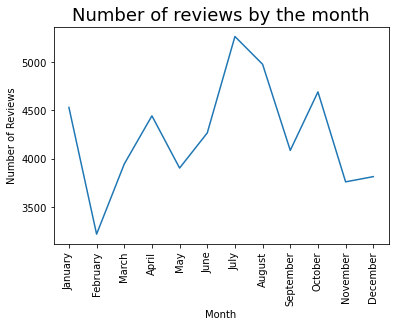

In [19]:
plt.plot(month_freq.keys(), month_freq.values())
plt.xlabel("Month")
plt.ylabel("Number of Reviews")
plt.title("Number of reviews by the month", fontsize=18)
plt.xticks(rotation=90)
plt.show()

#### 2.4 Which branch tends to yield higher-rated reviews? Which branch tends to yield lower-rated reviews?

First let's make separate dataframes for each branch.

In [20]:
florida = df[df.branch=="Universal Studios Florida"]
singapore = df[df.branch=="Universal Studios Singapore"]
japan = df[df.branch=="Universal Studios Japan"]

Since the three dataframes all vary in size, it is best to compare the amount of high-rated reviews proportionally. Let's create a function that prints the proportion of a certain rating of the dataset.

In [21]:
def print_rating_proportions(branch_df, name=""):
    branch_df_entries = branch_df.shape[0]
    branch_df_num_by_ratings = branch_df.groupby("rating").count().values[:,0]
    branch_df_perc = []
    for rating, amount in enumerate(branch_df_num_by_ratings, 1):
        percent = round(((amount/branch_df_entries)*100), 2)
        branch_df_perc.append(percent)
        print("Percentage of " + str(rating) + "-star ratings " + name + ":", f"{percent:.2f}%")
    return branch_df_perc
    

Florida's proportions of ratings:

In [22]:
florida_perc = print_rating_proportions(florida, name="in Florida")

Percentage of 1-star ratings in Florida: 4.49%
Percentage of 2-star ratings in Florida: 4.47%
Percentage of 3-star ratings in Florida: 9.67%
Percentage of 4-star ratings in Florida: 22.66%
Percentage of 5-star ratings in Florida: 58.71%


Japan's proportions of ratings:

In [23]:
japan_perc = print_rating_proportions(japan, name="in Japan")

Percentage of 1-star ratings in Japan: 4.28%
Percentage of 2-star ratings in Japan: 3.78%
Percentage of 3-star ratings in Japan: 12.30%
Percentage of 4-star ratings in Japan: 33.80%
Percentage of 5-star ratings in Japan: 45.84%


Singapore's proportions of ratings:

In [24]:
singapore_perc = print_rating_proportions(singapore, name="in Singapore")

Percentage of 1-star ratings in Singapore: 2.57%
Percentage of 2-star ratings in Singapore: 2.83%
Percentage of 3-star ratings in Singapore: 10.87%
Percentage of 4-star ratings in Singapore: 32.01%
Percentage of 5-star ratings in Singapore: 51.72%


Let's compare the proportions with all three branches by using a grouped bar plot.

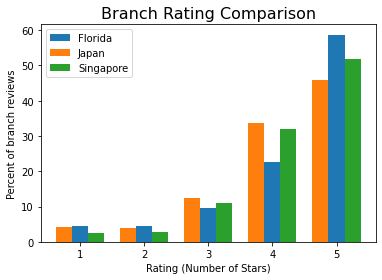

In [25]:
bar_width = 0.25
florida_placement = np.array([1.0, 2.0, 3.0, 4.0, 5.0])
japan_placement = florida_placement - bar_width
singapore_placement = florida_placement + bar_width

plt.bar(florida_placement, florida_perc, width=bar_width, label="Florida")
plt.bar(japan_placement, japan_perc, width=bar_width, label="Japan")
plt.bar(singapore_placement, singapore_perc, width=bar_width, label="Singapore")
plt.legend()
plt.xticks(range(1, 6), range(1, 6))
plt.xlabel("Rating (Number of Stars)")
plt.ylabel("Percent of branch reviews")
plt.title("Branch Rating Comparison", fontsize=16)
plt.show()

### 3. Preparing and Predicting Universal Studio Ratings

Can we predict a rating that will have 1-stars or 5-stars of a given Universal Studios review? 

#### 3.1 Preparing data for training and testing

In [26]:
# Note that we have already preprocessed the reviews during EDA in variable df_processed.
X = df_processed[(df.rating==1)|(df.rating==5)].reset_index().drop(columns=["index"]) # feature
y = df.rating[(df.rating==1)|(df.rating==5)].reset_index().drop(columns=["index"]) # label

Let's see how many 1-star and 5-star reviews are there.

In [27]:
print("Number of 1-star rated reviews:", len(y[y==1].dropna()))
print("Number of 5-star rated reviews:", len(y[y==5].dropna()))

Number of 1-star rated reviews: 1973
Number of 5-star rated reviews: 28202


Convert the text in X to vectors of numbers.

In [28]:
vectorizer = CountVectorizer()
vectorizer.fit(X.review_text)
X_vectors = vectorizer.transform(X.review_text)

Get the training and testing sets.

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X_vectors, y, test_size=0.2)
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shapeof y_train:", y_train.shape)
print("Shapeof y_test:", y_test.shape)

Shape of X_train: (24140, 22771)
Shape of X_test: (6035, 22771)
Shapeof y_train: (24140, 1)
Shapeof y_test: (6035, 1)


#### 3.2 Train and test ML model

Create and train a model to test. We will be using the Multinomial Naive Bayes model.

In [30]:
classifier = MultinomialNB()
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


#### 3.3. Determining the accuracy of our model

In [31]:
print("Accuracy (F1 Score):", "{:.4f}%".format(metrics.f1_score(y_test, y_pred, average="weighted")*100))

Accuracy (F1 Score): 96.7219%


### 4. Final Remarks

#### For topic 2.2:

Based on the plots in 2.2 and seeing which words are exclusive towards their rating, one could guess that those that did not enjoy Universal Studios, giving a rating of 1 star, had time-related issues.
On the other hand, those that enjoyed Universal Studios, giving a rating of 5 stars, enjoyed the scenery, specifically the Harry Potter ride.

#### For topic 2.3:

Based on the plot showing the ratings over the years, it seems like that many reviews took place between the years 2014 through 2019. There might have been a noticable decline from 2019 to 2021 in reviews due to COVID-19.
    
   Based on the plot showing the ratings of the months in a calendar year, it seems like reviews take place more in the summer, as July and August yields the highest number of reviews. This may be no suprise based on personal observations, as Universal Studios and other theme parks are popular in the summer, especially amongst the younger audience.

#### For topic 2.4:

By observing the bar plot above, one can conclude that the Florida branch proportionally yields high-rated reviews, giving 5 stars. However, the Florida branch yields the least amount of 4-star reviews out of all the branches. 

When we look at which branch tends to give lower-rated reviews, we would be looking at the Florida branch as they yield the most 1-star rated and 2-star rated reviews. On the other hand, the Singapore branch tends to receives the least amount of 1-star rated and 2-star rated reviews of the three branches.

#### For topic 3.3:

By observing the grouped bar plot, one can conclude that the Florida branch proportionally yields high-rated reviews, giving 5 stars. However, the Florida branch yields the least amount of 4-star reviews out of all the branches. 

When we look at which branch tends to give lower-rated reviews, we would be looking at the Florida branch as they yield the most 1-star rated and 2-star rated reviews. On the other hand, the Singapore branch tends to receives the least amount of 1-star rated and 2-star rated reviews of the three branches.

#### What may have skewed the results

Since the dataset only focused on reviews written in English, the results founded were not able to capture reviews writen in other languages. This could have affected the results founded in 2.3, when determining the most frequent words in 5-star and 1-star rated reviews, as well as the results founded in 3.3, when predicting reviews to be 1-star or 5-star rated.

#### Room for improvement

It would be better if there was work done to predict not only 1-star and 5-star rated reviews, but also 2-star, 3-star, and 4-star rated reviews, since we don't live in a world that uses 5-stars for ratings. I hope in the future I will be able to accomplish this.